# MARIO VAE LAB

Variational Autoencoders (VAEs) are a core technique in unsupervised learning.
How do they work? VAEs operate by encoding data (e.g. Mario levels) into a lower-dimensional latent space and subsequently decoding it to reconstruct the original data. However, unlike traditional autoencoders, VAEs introduce a probabilistic approach: they associate data with a distribution in the latent space rather than a fixed point. This ensures a consistent and smooth latent representation, and enables the generation of new data samples that mirror the characteristics of the original dataset.
Below you will be interacting with a VAE model which has been trained on Mario levels, and from which you can sample Mario levels!



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!cp 'path/to/file' 'path/to/drive'

In [3]:
import os
os.chdir("drive/My Drive/exercise_DL_pcg")

In [4]:
!ls

all_levels_onehot.npz		   plotting_utilities.py  requirements.txt  vae_mario.py
example_sampling_random_levels.py  __pycache__		  sprites
models				   readme.md		  train_vae.py


In [5]:
import os
import torch
import matplotlib.pyplot as plt

from vae_mario import VAEMario
from plotting_utilities import plot_decoded_level

In [6]:
# Loading the model
model_name = "mario_vae_zdim_2_overfitted"
z_dim = 2
vae = VAEMario(z_dim=z_dim)
vae.load_state_dict(torch.load(f"./models/{model_name}.pt"))


VAEMario(
  (encoder): Sequential(
    (0): Linear(in_features=2156, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (fc_mu): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (fc_var): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2156, bias=True)
  )
)


<All keys matched successfully>

In [7]:
# 1---Sampling random zs
num_levels=6
zs = 2.5 * torch.randn((num_levels, z_dim))

In [8]:
# 2--- Getting levels from the sampled seeds using the decoder
levels = vae.decode(zs)
print(levels.shape)
# Can you explain the shape of the levels tensor? Notably: why is the "11" there?
#it is the number of block types, six is the number of levels, the other 2 are the height and width
# If needed, look at it.





torch.Size([6, 11, 14, 14])


In [9]:
# 3---Converting the levels to images with the utility function
level_imgs = [plot_decoded_level(level) for level in levels]


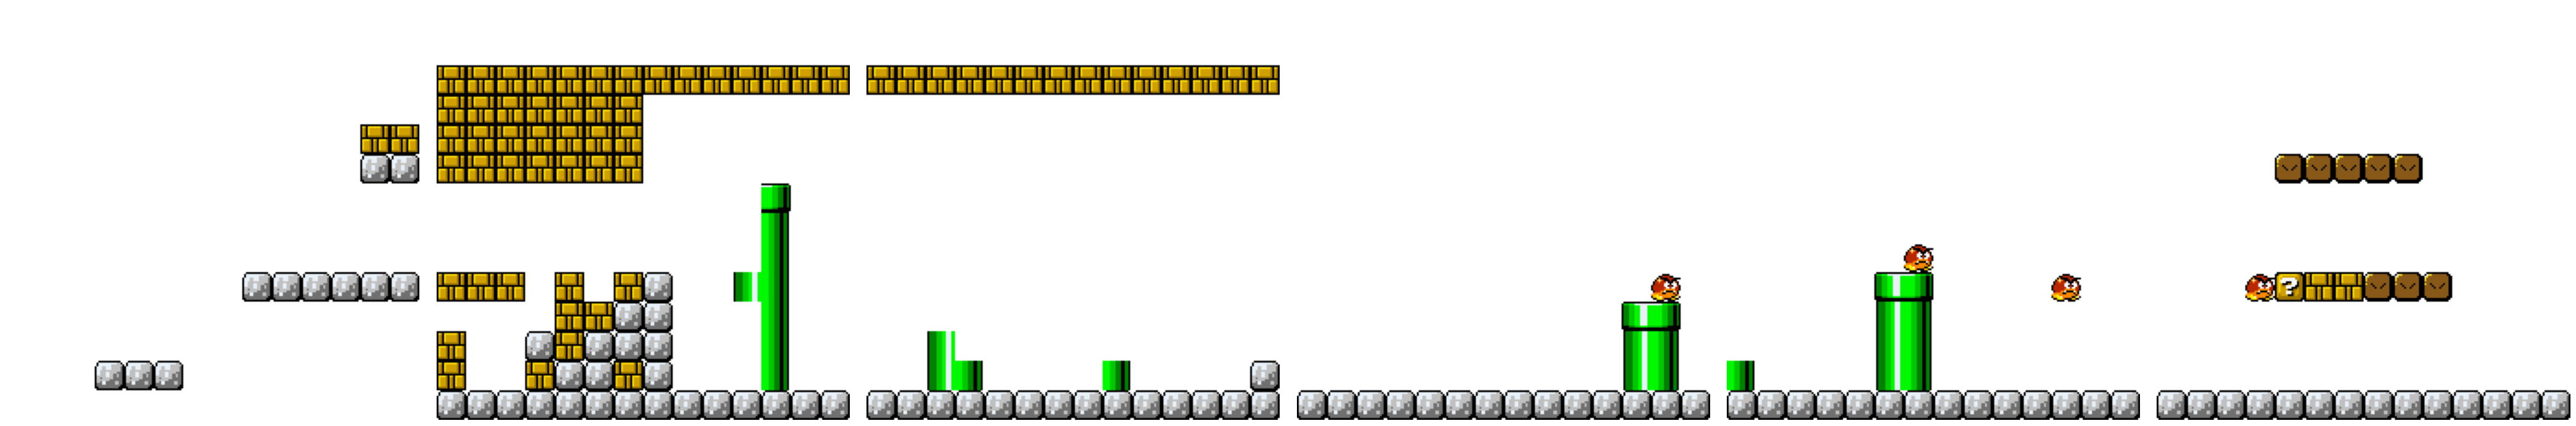

In [10]:
# Plotting
_, axes = plt.subplots(1, num_levels, figsize=(7 * num_levels, 7))
for level_img, ax in zip(level_imgs, axes):
    ax.imshow(level_img)
    ax.axis("off")

plt.tight_layout()
plt.show()


# Latent Variable Evolution


### EXERCISE 1: Sample from the VAE and then implement some search algorithm of choice to search the latent space for a particular level (e.g. one with many ground tiles)

In [11]:
#Refer to this to see how differents elements are encoded

encoding = {
    "X": 0, #stone
    "S": 1, #breakable stone
    "-": 2, #air
    "?": 3, #question
    "Q": 4, #depleted question
    "E": 5, #goomba
    "<": 6, #left pipe head
    ">": 7, #right pipe head
    "[": 8, #left pipe
    "]": 9, #right pipe
    "o": 10, #coin
}

# After decoding the levels with vae.decode, you can use torch.argmax(level, dim=0) of each level to get the actual level sampled from the VAE (not probabilistic)
#NB argmax on the dimension i want.
z_dim=2
vae = VAEMario()
num_levels=6
zs = 2.5 * torch.randn((num_levels, z_dim))

levels=vae.decode(zs)
print(levels.shape)

bestLvl = None
bestCount = 0
counts=[]

for i in range(num_levels):
    level = torch.argmax(levels[i], dim=0)
    count= (level == encoding["X"]).sum()
    counts.append(count)
    if count > bestCount:
        bestLvl = level
        bestCount = count


print(f'the best level has {bestCount} ground tiles')
print(counts)



VAEMario(
  (encoder): Sequential(
    (0): Linear(in_features=2156, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (fc_mu): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (fc_var): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2156, bias=True)
  )
)
torch.Size([6, 11, 14, 14])
the best level has 21 ground tiles
[tensor(20), tensor(11), tensor(19), tensor(17), tensor(21), tensor(19)]


### EXERCISE 2: Interactive Evolution (OPTIONAL)

Code a small interactive evolution loop, evolving long levels (composed of a sequence of 6 levels put together for instance).
The fitness shall be given by a human agent prompted to select one level among 4 for instance.
You can mix mutation and/or cross-over the elites to form the next level generation.

See if you observe evolution of these levels which corresponds to your selection (you could select the most complicated, or the ones with the most piles etc).

Of course, it would depends of the encoding you choose for your "DNA" for each level: e.g. sequence of 2D-float  (ie array dim(6,2)), or sequence of integer indices of a preselected pools of levels (e.g. from 100 levels sampled from the latent space), etc.


In [14]:
import random
pool = list(range(100))
size = 20
sequence= 6

def generateLevel():
    return [random.choice(pool) for _ in range(sequence)]

def evaluateLevel(level):
    print("Evaluate this level:")
    print(level)
    print("Select the best level (1 to 6):")
    selection = int(input())
    return selection

population = [generateLevel() for _ in range(size)]

for g in range(10):
    scores = [evaluateLevel(level) for level in population]

    best = sorted(range(size), key=lambda i: scores[i], reverse=True)
    best =[ population[i] for i in best[:size // 2]]




Evaluate this level:
[84, 99, 3, 26, 33, 36]
evaluate level (1 to 6):
1
Evaluate this level:
[96, 85, 6, 70, 33, 26]
evaluate level (1 to 6):
1
Evaluate this level:
[21, 39, 59, 12, 10, 12]
evaluate level (1 to 6):
2
Evaluate this level:
[40, 23, 35, 4, 84, 11]
evaluate level (1 to 6):
3
Evaluate this level:
[32, 62, 80, 68, 25, 66]
evaluate level (1 to 6):
2
Evaluate this level:
[5, 59, 10, 67, 97, 0]
evaluate level (1 to 6):
2
Evaluate this level:
[26, 21, 21, 35, 56, 91]
evaluate level (1 to 6):
3
Evaluate this level:
[71, 11, 92, 48, 93, 85]
evaluate level (1 to 6):
3
Evaluate this level:
[65, 52, 83, 32, 86, 80]
evaluate level (1 to 6):
3
Evaluate this level:
[39, 82, 92, 48, 38, 40]
evaluate level (1 to 6):
2
Evaluate this level:
[21, 88, 99, 43, 12, 6]
evaluate level (1 to 6):
4
Evaluate this level:
[48, 74, 8, 62, 80, 64]
evaluate level (1 to 6):
4
Evaluate this level:
[43, 29, 59, 92, 2, 93]
evaluate level (1 to 6):
4
Evaluate this level:
[35, 14, 55, 17, 39, 69]
evaluate leve

KeyboardInterrupt: ignored

# GOING FURTHER (OPTIONAL)
Procedural Content Generation (PCG) algorithms provide a technique to generate complex and diverse environments in an automated way. However, while generating content with PCG methods is often straightforward, generating meaningful content that reflects specific intentions and constraints remains challenging.  

Throw an eye at MarioGPT, a recent work using Large Language Models (LLMs) for text-guided Procedural Content Generation, generating Super Mario Bros levels, and also leveraging novelty search and evolutionary methods to generate diverse levels with varying play-style (The diversity is measured from the player path).
Here the repo:
https://github.com/shyamsn97/mario-gpt
Here the paper:
https://arxiv.org/abs/2302.05981

Also, in the repo you will find a code to run a AI-Mario Agent (A star) to evaluate the playability of the levels (you can notably consider the time for the agent to complete a level or success percentage). This would also avoid non playable levels.